In [ ]:
!pip install torch
!pip install transformers
!pip install tqdm
!pip install opencc
!pip install -U sentence-transformers
!pip install tensorboard
from IPython.display import clear_output
clear_output()

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sentence_transformers import SentenceTransformer, models, SentencesDataset, InputExample, losses, evaluation
from tqdm import tqdm
import random
import json
import opencc
from sklearn.manifold import TSNE
import seaborn as sns
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
from transformers import AdamW
import matplotlib.pyplot as plt

## Hyper parameter

In [2]:
tokenizer_LM = "../bert-base-chinese"
NO = 1
LM_SET = ["../bert-base-chinese", "../ckiplab/bert-base-chinese", "../hfl/chinese-bert-wwm", "../hfl/rbtl3"]
MODEL_NAME_SET = ["base", "ckip", "wwm", "rbtl3"]
LM = LM_SET[NO]
MODEL_NAME = MODEL_NAME_SET[NO]

DATASET = "SMP2018"
TRAIN_BATCH_SIZE = 32
TEST_BATCH_SIZE = 64
MODEL_PATH = f"model/softmaxCls_{DATASET}/{MODEL_NAME}" # svae/load model name/path
EPOCHS = 5
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:", device)

device: cuda:0


## Utility

In [3]:
from datetime import datetime,timezone,timedelta
def timestamp(msg=""):
    dt1 = datetime.utcnow().replace(tzinfo=timezone.utc)
    dt2 = dt1.astimezone(timezone(timedelta(hours=8))) # 轉換時區 -> 東八區
    print(str(dt2)[:-13] + '\t' + msg)
    return (str(dt2)[:-13] + '\t' + msg)    

In [4]:
# high-level 顯示此模型裡的 modules
def model_info(model):
#     print(model.device)
    print("""
    name            module
    ----------------------""")
    for name, module in model.named_children():
        if name == "bert" or name=="0":
            for n, _ in module.named_children():
                print(f"{name}:{n}")
    #             print(_)
        else:
            print("{:15} {}".format(name, module))

In [5]:
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

In [6]:
def emb_visualize(bert_model):
    df = pd.read_csv(f"data/{DATASET}/train.tsv", sep='\t')
    # assert len(dataloader.dataset) == df.shape[0]
    df = df.sort_values(by="labels", ignore_index=True)
    # _, emb = get_predictions(model, trainLoader, compute_acc=False, get_emb=True)
    emb = bert_model.encode(df["texts"].tolist(), convert_to_numpy=True)
    low_dim_emb = TSNE(n_components=2, perplexity=30).fit_transform(emb)

    df["f1"] = low_dim_emb[:, 0]
    df["f2"] = low_dim_emb[:, 1]
    emb_fig = sns.relplot(
        data=df, x="f1", y="f2",
        hue="labels", alpha=0.7,
        kind="scatter")
    emb_by_cls_fig = sns.relplot(
        data=df, x="f1", y="f2",
        col="labels", col_wrap=4,
        kind="scatter")
    return emb_fig, emb_by_cls_fig

## Data Preprocess

In [8]:
def get_bert_data(mode, file_path):
    assert mode in ["train", "test", "dev"]
    df = pd.read_csv(file_path, sep='\t')
    df = df.sort_values(by=["labels"], ignore_index=True)
    src_labels = sorted(set(df.labels.tolist()))
    num_labels = len(src_labels)
    df["labels"] = [src_labels.index(l) for l in df.labels.tolist()]

    bert_data = []
    texts = df["texts"]
    labels = df["labels"]
    
    for label in range(len(src_labels)):
        item_num = len(df[df["labels"] == label])
        for i in range(item_num):
            for j in range(i+1, item_num):
                bert_dict = InputExample(texts=[texts[label+i], texts[label+j]], label=label)
                bert_data += [bert_dict]
                
#     for label in range(len(src_labels)):
#         item_num = len(df[df["labels"] == label])
#         rand_idx = np.arange(150) # 75 for average num in intent classes
#         np.random.shuffle(rand_idx)
#         rand_idx %= item_num
#         for i, idx in enumerate(rand_idx):
#             if i == 149:
#                 break
#             bert_dict = InputExample(texts=[texts[label+idx], texts[label+rand_idx[i+1]]], label=label)
#             bert_data += [bert_dict]
    
    torch.save(bert_data, f"bert_data/{DATASET}/sbert_softmax_{mode}.pt")
        
    if mode == "train":
        return bert_data, num_labels #List[Dict[List]] = List[tokenizer output]
    else:
        return bert_data

In [7]:
"""train data"""
sbert_train = torch.load(f"bert_data/{DATASET}/sbert_softmax_train.pt")
print(len(sbert_train))
num_labels = 41 if DATASET=="base" else 31

197914


In [8]:
"""testing data"""
sbert_test = torch.load(f"bert_data/{DATASET}/sbert_softmax_test.pt")
len(sbert_test)

22060

## Model and DataSet

In [9]:
bert = models.Transformer(LM, max_seq_length=128)
bert_hidden_size = bert.get_word_embedding_dimension()
pooler = models.Pooling(bert_hidden_size) # necessary for SentenceTransformer from scratch with dense

bert_model = SentenceTransformer(modules=[bert, pooler], device=device)
softmax_loss = losses.SoftmaxLoss(model=bert_model, \
                                  sentence_embedding_dimension=bert_hidden_size, \
                                  num_labels=num_labels)
model_info(bert_model)


    name            module
    ----------------------
0:auto_model
1               Pooling()


## Train & validate

In [10]:
"""tensorboard logger"""
# writer = SummaryWriter(f"runs/{DATASET}/{MODEL_NAME}/{str(ALPHA).replace('.','')}_{EPOCHS}")

'tensorboard logger'

In [11]:
train_from = 0
if MODEL_PATH.find(".pt") != -1:
    model.load_state_dict(torch.load(MODEL_PATH)) #######
    p = MODEL_PATH.rfind('_')
    train_from = int(MODEL_PATH[p+1 : -3])
    MODEL_PATH = MODEL_PATH[: p-2]

In [12]:
trainSet = SentencesDataset(sbert_train, bert_model)
trainLoader = DataLoader(trainSet, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
testSet = SentencesDataset(sbert_test, bert_model)
testLoader = DataLoader(testSet, batch_size=TEST_BATCH_SIZE)

In [ ]:
evaluator = evaluation.LabelAccuracyEvaluator(trainLoader, softmax_model=softmax_loss, name=f"{MODEL_NAME}_train")
bert_model.fit(train_objectives=[(trainLoader, softmax_loss)], epochs=EPOCHS, \
               optimizer_params={'lr':3e-5}, evaluation_steps=3000, evaluator=evaluator,\
               output_path=f"{MODEL_PATH}_bert_E_{EPOCHS}")

In [15]:
evaluator = evaluation.LabelAccuracyEvaluator(testLoader, name=f"{MODEL_NAME}_test", softmax_model=softmax_loss)
acc = evaluator(bert_model)
print(f"[EPOCHS {EPOCHS}] testing acc: {acc:.6f}")
# writer.add_scalar('Acc/test', acc, EPOCHS)

[EPOCHS 5] testing acc: 0.451224


## Visualization

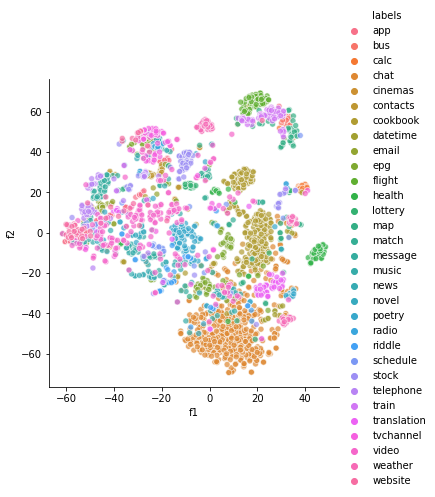

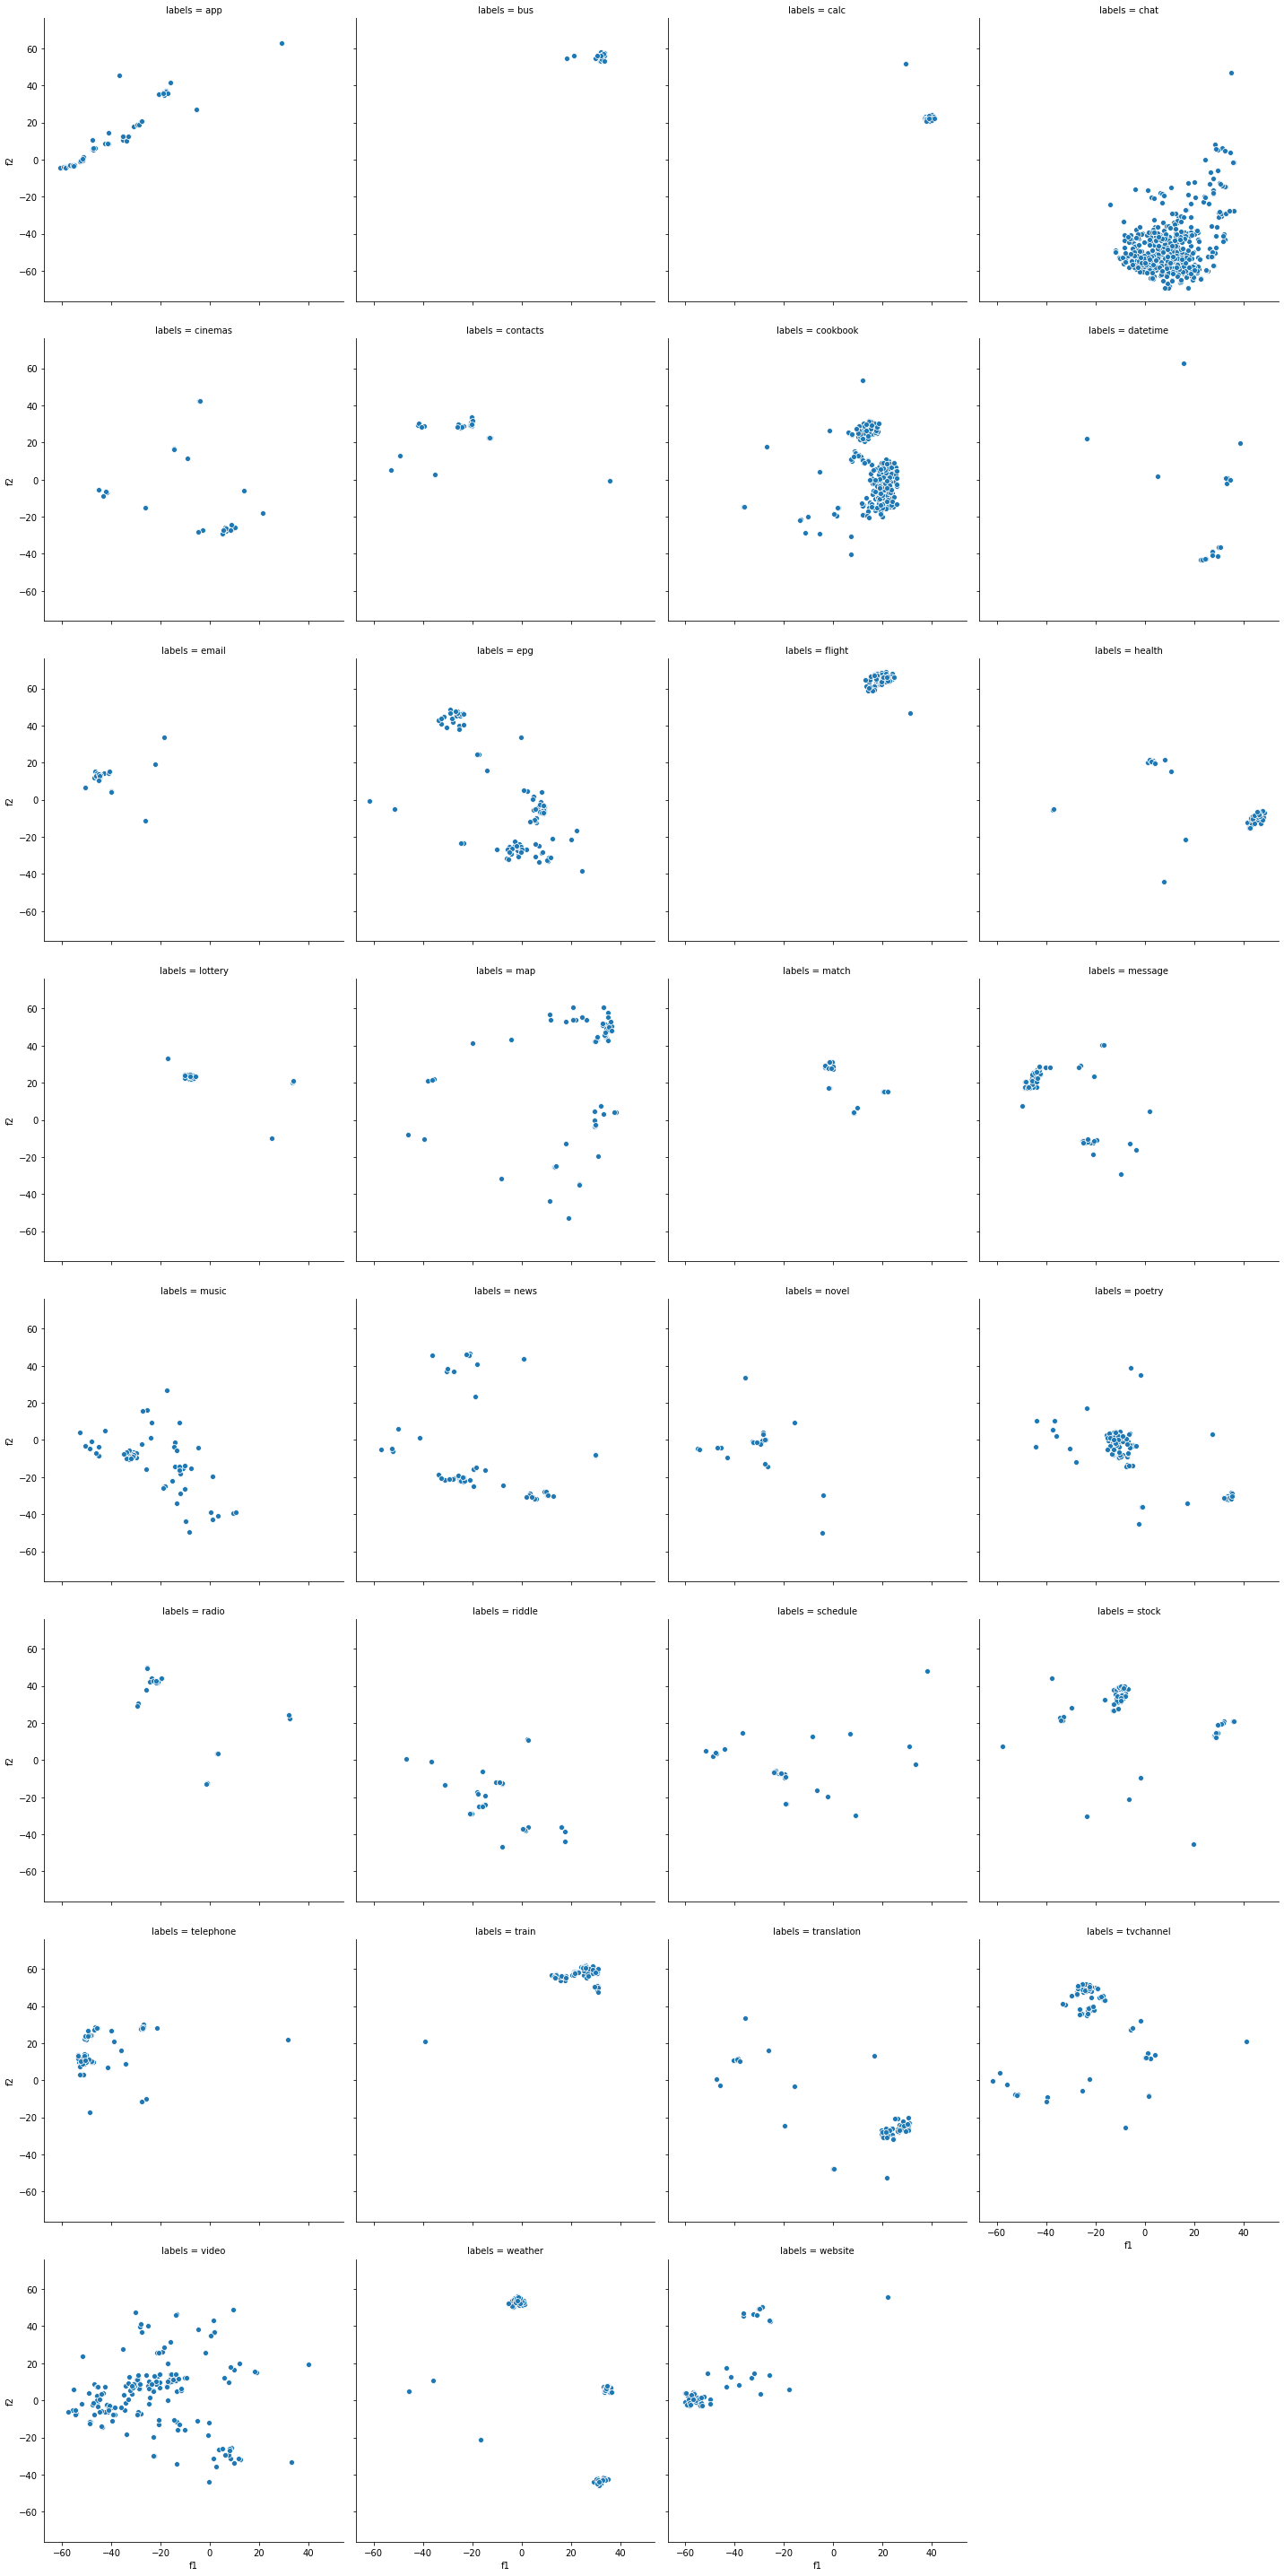

In [19]:
emb_fig, emb_by_cls_fig = emb_visualize(bert_model)

In [ ]:
emb_fig.savefig(f"runs/{DATASET}/{MODEL_NAME}/{str(ALPHA).replace('.','')}_{EPOCHS}/emb.png")
emb_by_cls_fig.savefig(f"runs/{DATASET}/{MODEL_NAME}/{str(ALPHA).replace('.','')}_{EPOCHS}/emb_bycls.png")

## Test

In [ ]:
testSet = intent_Dataset("test", bert_test)
testLoader = DataLoader(testSet, batch_size=TEST_BATCH_SIZE)

In [ ]:
model = BertForSequenceClassification.from_pretrained(LM, num_labels=num_labels, return_dict=True)

In [ ]:
for e in range(1,9):
    model.load_state_dict(torch.load(f"{MODEL_PATH}_E_{e}.pt"))
    model.eval()
    model = model.to(device)
    _, acc = get_predictions(model, testLoader, compute_acc=True)
    print(f"[epoch {e}] testing acc: {acc:.6f}")

---